In [6]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_crossentropy

import os
import numpy as np
import matplotlib.pyplot as plt

In [106]:
def Kernel(x, x0):
    sigma = 0.8
    protonFraction = 0.4
    norm = protonFraction/(np.sqrt(2.*np.pi)*sigma)
    return(norm*np.exp(-(x - x0)**2./(2.*sigma**2.)))

def testDataGen():
    A = 197
    yBeam = 5.36
    slope = 0.5
    sigmaEtas = 0.2
    
    # generate input data
    nBaryons = np.random.randint(0, 2*A)
    randX = np.random.uniform(0, 1, size=nBaryons)
    etasBaryon = 1./slope*np.arcsinh((2.*randX - 1)*np.sinh(slope*yBeam))
    etasArr = np.linspace(-7, 7, 141)
    dNBdetas = np.zeros(len(etasArr))
    norm = 1./(np.sqrt(2.*np.pi)*sigmaEtas)
    for iB in etasBaryon:
        dNBdetas += norm*np.exp(-(etasArr - iB)**2./(2.*sigmaEtas**2.))
    
    # generate test data with convolution with a kernel
    dNpdy = np.zeros(len(etasArr))
    detas = etasArr[1] - etasArr[0]
    for i in range(len(etasArr)):
        dNpdy[i] = sum(Kernel(etasArr, etasArr[i])*dNBdetas)*detas
        
    # generate fake data with random noise
    dNBdetasFake = np.random.uniform(0.0, dNBdetas.max(), size=len(etasArr))
    dNpdyFake = np.random.uniform(0.0, dNpdy.max(), size=len(etasArr))
    return(etasArr, dNBdetas, dNpdy, dNBdetasFake, dNpdyFake)

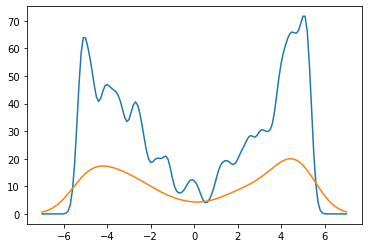

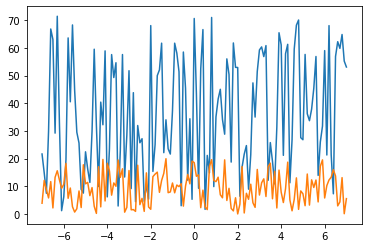

In [113]:
x, y1, y2, y3, y4 = testDataGen()
fig = plt.figure()
plt.plot(x, y1)
plt.plot(x, y2)
fig = plt.figure()
plt.plot(x, y3)
plt.plot(x, y4)

In [115]:
def generateData(size=500):
    print('Generating Data...')
    dataArr = []
    labelArr = []  
    for iev in range(size):
        x, y1, y2, y3, y4 = testDataGen()
        
        dim = len(x)
        
        # real data
        x = np.hstack((y1.reshape(dim, 1), y2.reshape(dim, 1)))
        dataArr.append(x)
        labelArr.append(np.ones((dim, 2)))
        
        # fake data
        x = np.hstack((y3.reshape(dim, 1), y4.reshape(dim, 1)))
        dataArr.append(x)
        labelArr.append(np.zeros((dim, 2)))
    print("done")
    return(np.array(dataArr), np.array(labelArr))

In [94]:
def trainModel(dim):
    #Sequential model
    model = Sequential()

    #Input layer
    model.add(Dense(16, activation='relu', input_shape=(dim, 2)))

    #Hidden Layer
    model.add(Dense(16, activation='relu', input_shape=(dim, 2)))
    model.add(Dense(4, activation='relu', input_shape=(dim, 2)))

    #Output layer - Binary
    model.add(Dense(2, activation='sigmoid', input_shape=(dim, 2)))

    model.summary()
    
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])
    return(model)

In [128]:
def trainModel2(dimShape):
    #Sequential model
    model = Sequential([
        Dense(units=32, activation='relu', input_shape=dimShape),
        Dense(units=64, activation='relu'),
        Dense(units=2, activation='softmax')
    ])
    model.summary()
    
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])
    return(model)

In [129]:
data, label = generateData(1000)

Generating Data...
done


In [130]:
model = trainModel2((data.shape[1], data.shape[2]))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 141, 32)           96        
                                                                 
 dense_32 (Dense)            (None, 141, 64)           2112      
                                                                 
 dense_33 (Dense)            (None, 141, 2)            130       
                                                                 
Total params: 2,338
Trainable params: 2,338
Non-trainable params: 0
_________________________________________________________________


In [131]:
Nepochs = 30
#Fit will actually train the model.
# X: input of shape (141,2)
# Y: target catagorization, either 1 or 0. Shape (141,2) for consistancy with X
model.fit(
    x=np.array(data),
    y=np.array(label),
    epochs=Nepochs,
    shuffle=True,
    validation_split=0.1,
    use_multiprocessing=True,
    workers=25,
    verbose=2
)

Epoch 1/30
57/57 - 1s - loss: 1.0662 - accuracy: 0.0155 - val_loss: 0.8441 - val_accuracy: 0.0437 - 746ms/epoch - 13ms/step
Epoch 2/30
57/57 - 0s - loss: 0.7176 - accuracy: 0.2062 - val_loss: 0.6435 - val_accuracy: 0.4957 - 151ms/epoch - 3ms/step
Epoch 3/30
57/57 - 0s - loss: 0.6334 - accuracy: 0.5131 - val_loss: 0.6282 - val_accuracy: 0.5329 - 156ms/epoch - 3ms/step
Epoch 4/30
57/57 - 0s - loss: 0.6221 - accuracy: 0.5511 - val_loss: 0.6172 - val_accuracy: 0.5258 - 147ms/epoch - 3ms/step
Epoch 5/30
57/57 - 0s - loss: 0.6126 - accuracy: 0.5228 - val_loss: 0.6081 - val_accuracy: 0.4576 - 158ms/epoch - 3ms/step
Epoch 6/30
57/57 - 0s - loss: 0.6029 - accuracy: 0.4953 - val_loss: 0.5983 - val_accuracy: 0.5594 - 186ms/epoch - 3ms/step
Epoch 7/30
57/57 - 0s - loss: 0.5937 - accuracy: 0.5316 - val_loss: 0.5901 - val_accuracy: 0.5634 - 154ms/epoch - 3ms/step
Epoch 8/30
57/57 - 0s - loss: 0.5859 - accuracy: 0.5485 - val_loss: 0.5833 - val_accuracy: 0.5609 - 146ms/epoch - 3ms/step
Epoch 9/30
57/5